In [1]:
import os
import re 
import cv2
import scipy
import torch
import random
import argparse
import numpy as np
from torch import nn
from PIL import Image
import torchvision as tv
from scipy.signal import *
from tensorboardX import SummaryWriter
import torchvision.models as models
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from skimage import transform,data

In [2]:
def load_gt_bbox(filepath):#相当于是钥匙，用于打开每个房间的门
    with open(filepath) as f:
        data = f.read()
        objs = re.findall('\d+ \d+ \d+ \d+ \d+', data)
        nums_obj = len(objs)
        gtBBs = np.zeros((nums_obj, 4),dtype=np.int64)
        for idx, obj in enumerate(objs):
            info = re.findall('\d+', obj)
            x1 = float(info[0])
            y1 = float(info[1])
            x2 = float(info[2])
            y2 = float(info[3])
            gtBBs[idx, :] = [x1, y1, x2, y2]
        return gtBBs

In [3]:
class HeatMap(object):
    def __init__(self, radius = 3):
        self.radius = radius
        
    def _generate_heatmap(self, center, sigma):
        X = self.X - center[1]
        Y = self.Y - center[0]
        DX = X ** 2 
        DY = Y ** 2
        EX = 2.0 * sigma[1] * sigma[1]
        EY = 2.0 * sigma[0] * sigma[0]
        heatmap = torch.exp(-(DX / EX + DY / EY) / 2)#/2 * sigma[0] * sigma[1]
        return heatmap
                            
    def __call__(self, sample):
        X1 = torch.linspace(1, sample['image'].shape[0], sample['image'].shape[0]).cuda()#linspace(start, end, steps=100, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False)
        Y1 = torch.linspace(1, sample['image'].shape[1], sample['image'].shape[1]).cuda()#原来慢是因为python循环很慢，所以用c++来做
        self.X,self.Y = torch.meshgrid([X1, Y1])#生成原图中每个点的坐标，meshgrid内部实现是c++
        heatmaps = torch.cat([torch.unsqueeze(
        self._generate_heatmap(
        ((i[2] + i[0]) / 2, (i[3] + i[1]) / 2),
        ((i[2] - i[0]) / (2 * self.radius), (i[3] - i[1]) / (2 * self.radius))).cpu().data,
        0) for i in sample['label']], 0)#这里是将所有的热力图拼起来，一个热力图是h w,m个热力图拼起来就是 h w m,m 就是有m个小车，有m个热力图
                            #因为车离的很近，概率分布就有重叠，重叠的处理，原来的方法是后面的车，覆盖了前面的车，
        sample['heatmap'] = heatmaps.max(0)[0].numpy()
        #sample['heatmap_patch'] = heatmaps[sample['patch_index']]
        return sample

In [4]:
class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        sample['image'] = torch.tensor(np.transpose(sample['image'],(2, 0, 1)),dtype = torch.float32) / 255#h（0）w（1）c（2）是012，这里要变成chw（所以是201）
        sample['exemplar'] = torch.tensor(np.transpose(sample['exemplar'],(2, 0, 1)),dtype = torch.float32) / 255
        sample['heatmap'] = torch.tensor(sample['heatmap'],dtype = torch.float32)
        sample.pop('label')#把label去掉，“过河拆桥”

        return (sample)
    

class Randomcrop(object):
    def __init__(self):
        pass
    def __call__(self,sample):
        img = sample['image']
        BB = sample['label']
        slice = random.sample(list(BB), 1)
        roi = img[(slice[[0][0]][1]):(slice[[0][0]][3]), (slice[[0][0]][0]):(slice[[0][0]][2])]
        sample['exemplar'] = roi
        return sample                                    
                                        
    
class Resize(object):
    def __init__(self, image_output_size, exemplar_output_size, heatmap_output_size):
        self.image_output_size = image_output_size
        self.exemplar_output_size = exemplar_output_size
        self.heatmap_output_size = heatmap_output_size
    def __call__(self, sample):
        sample['image'] = cv2.resize(sample['image'], self.image_output_size)
        sample['exemplar'] = cv2.resize(sample['exemplar'], self.exemplar_output_size)
        sample['heatmap'] = cv2.resize(sample['heatmap'], self.heatmap_output_size)
        return sample
    
      
    
class CarDataset(Dataset):
    def __init__(self, root_path, label_path, transforms=None, is_train=True):
        self.root_path = root_path
        self.label_path = label_path
        self.file_paths = []
        self.label_paths = []
        self.transforms = transforms
        
        for sub_dir in os.listdir(root_path):#os.listdir() 方法用于返回指定的文件夹包含的文件或文件夹的名字的列表。
            sub_path = root_path + sub_dir
            if sub_path.endswith('png'):
                self.file_paths.append(sub_path)#建立file_paths列表。相当于是房间号  
        self.file_paths = sorted(self.file_paths)
        
        for lab_dir in os.listdir(label_path):
            lab_path = label_path + lab_dir
            if lab_path.endswith('txt'):
                self.label_paths.append(lab_path)#append() 方法用于在列表末尾添加新的对象。相当于是钥匙号    
        self.label_paths = sorted(self.label_paths)
        
        if is_train:
            self.file_paths = self.file_paths[: len(self.file_paths) * 8 // 10]
            self.label_paths = self.label_paths[: len(self.label_paths) * 8 // 10]
        else:
            self.file_paths = self.file_paths[len(self.file_paths) * 8 // 10:]
            self.label_paths = self.label_paths[len(self.label_paths) * 8 // 10:]
            
        if (len(self.file_paths) == len(self.label_paths)):
            pass
        else:
            print("Error")
    
    
    
    def __len__(self):
        return len(self.file_paths)
    
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]#得到第几张图片
        label_paths = self.label_paths[idx]
        image = cv2.imread(img_path)
        label = load_gt_bbox(label_paths)
        sample = {'image':image, 'label':label}#是个字典
        #sample = (image, label)#是一个元祖tuple
        #print(img_path)
        if not self.transforms is None:
            sample = self.transforms(sample)  
        return sample

In [5]:
car_dataset = CarDataset(root_path = 'datasets/CARPK_devkit/data/Images/',
                         label_path = 'datasets/CARPK_devkit/data/Annotations/',
                           transforms = tv.transforms.Compose([
                               Randomcrop(),
                               HeatMap(),
                               Resize((255, 255), (255, 255), (64, 64)),
                               ToTensor()    
                          ]))
#print(car_dataset)
#print(len(car_dataset))
#print(car_dataset[201])
dst = car_dataset[201]

In [6]:
imgimg = dst['image']
imgexemplar = dst['exemplar']
imgheatmap = dst['heatmap']
#plt.imshow(imgheatmap)
#print(imgheatmap.shape)

In [7]:
class CountingNet(nn.Module):
    def __init__(self):
        super(CountingNet, self).__init__()
        resnet = tv.models.resnet50(pretrained=True)
        self.resnet_layer = torch.nn.Sequential(*list(resnet.children())[:6])
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.conv1 = nn.Conv2d(1024, 256, 3, 1, 1)
        self.convt1 = nn.ConvTranspose2d(256, 256, 3, 2, 1)
        self.conv2 = nn.Conv2d(256, 1, 3, 1, 1)
    
    def forward(self, exemplar, count_image):
        exemplar = self.resnet_layer(exemplar)
        exemplar = self.maxpool(exemplar)
        exemplar = exemplar.expand(exemplar.shape[0], 512, 32, 32)
        count_image = self.resnet_layer(count_image)
        concatenation = torch.cat((exemplar, count_image),1)#拼接
        relation = self.conv1(concatenation)
        relation = self.convt1(relation)
        prediction = self.conv2(relation)
        
        return prediction

In [8]:
model = CountingNet()
model(torch.rand(1, 3, 63, 63), torch.rand(1, 3, 255, 255)).shape

torch.Size([1, 1, 63, 63])

In [9]:
batch_size = 40
car_dataset = CarDataset(root_path = 'datasets/CARPK_devkit/data/Images/',
                         label_path = 'datasets/CARPK_devkit/data/Annotations/',
                           transforms = tv.transforms.Compose([
                               Randomcrop(),
                               HeatMap(),
                               Resize((255, 255), (255, 255), (63, 63)),
                               ToTensor()    
                          ]))
car_loader = DataLoader(dataset = car_dataset, 
                          batch_size = batch_size, 
                          shuffle = True,#   #把数据打乱 
                          num_workers = 0)   #多线程读图片，即用了32个线程
    
vali_dataset = CarDataset(root_path = 'datasets/CARPK_devkit/data/Images/',
                          label_path = 'datasets/CARPK_devkit/data/Annotations/', 
                           transforms = tv.transforms.Compose([
                               Randomcrop(),
                               HeatMap(),
                               Resize((255, 255), (255, 255), (63, 63)),
                               ToTensor()]),is_train = False)
vali_loader = DataLoader(dataset = vali_dataset, 
                          batch_size = batch_size, 
                          shuffle = True,   #把数据打乱 
                          num_workers = 0)   #多线程读图片，即用了32个线程
    
model_single = CountingNet()
devices = [0, 1, 2, 3]
model = nn.DataParallel(model_single, device_ids = devices).cuda()
criterion = torch.nn.MSELoss()

In [10]:
optimizer = torch.optim.SGD(params = model.parameters(), lr= 1e-2, weight_decay= 1e-6, momentum= 0.9)

In [11]:
for epoch in range(10): 
    model.train()
    for data in car_loader:
        batch_img = data['image'].cuda() #从迭代器中取出大图
        batch_exemplar = data["exemplar"].cuda() #从迭代器中取出小图
        batch_heatmap = data['heatmap'].cuda() #从迭代器中取出热力图
        optimizer.zero_grad()    #优化器梯度初始化为0
        output = model(batch_exemplar, batch_img)
        output = output.squeeze()
       # print(output.shape)
        loss = criterion(output, batch_heatmap)
        writer.add_scalar('data/scalar1', loss, step)
        loss.backward()
        optimizer.step()
    torch.save(model.state_dict(), 'counting.pt')

In [13]:
print(loss)

tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward>)


In [15]:
print(output.shape)

torch.Size([38, 63, 63])


In [17]:
print(output)

tensor([[[ 0.0804,  0.0261,  0.0374,  ...,  0.0444,  0.0107, -0.0197],
         [ 0.1136,  0.0846,  0.0108,  ...,  0.0349,  0.0014,  0.0064],
         [ 0.1366,  0.0458, -0.0037,  ...,  0.0088, -0.0051, -0.0241],
         ...,
         [ 0.1108,  0.2210,  0.1969,  ...,  0.1702,  0.1069,  0.0329],
         [ 0.1501,  0.2664,  0.2365,  ...,  0.0937,  0.0334,  0.0335],
         [ 0.1012,  0.1393,  0.1150,  ...,  0.0014, -0.0020, -0.0056]],

        [[-0.0047, -0.0091, -0.0165,  ...,  0.0151,  0.1177,  0.0573],
         [ 0.0154,  0.0170, -0.0010,  ...,  0.0127,  0.1531,  0.1221],
         [-0.0122, -0.0081, -0.0309,  ...,  0.0232,  0.1975,  0.1273],
         ...,
         [ 0.0007,  0.0203,  0.0028,  ...,  0.0683,  0.1484,  0.1051],
         [ 0.0212,  0.0260, -0.0083,  ...,  0.0535,  0.1045,  0.1117],
         [ 0.0231,  0.0184, -0.0048,  ...,  0.0193,  0.0631,  0.0663]],

        [[ 0.1044,  0.1316,  0.0777,  ...,  0.0244,  0.0227, -0.0255],
         [ 0.2089,  0.2895,  0.1870,  ...,  0

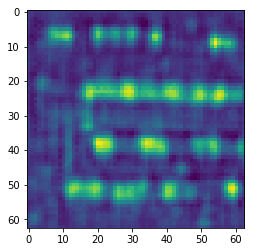

In [30]:
plt.imshow(output[32].detach().data)

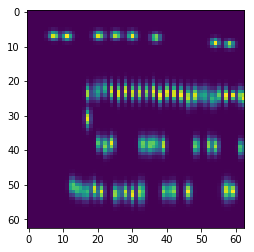

In [31]:
plt.imshow(batch_heatmap [32].detach().data)